## TO DO: 
#### Understand what is the source of the perfect training accuracy: 
* data leakage? overfitting? unbalanced dataset? 
* do cross-validation 
* Look at the heatmap of the motor assessments (UPDRS & MSEADLG) to see if there are high correlation with NHY
* Logistic Regression: play on the C parameter
* RF: play on the parameters that can reduce overfitting

* prepare the time-series dataset: sequence length: 4 with min of 2 (rest is padding), with 3 as input. 

#### Features highly correlated with NHY feature:
* NP3FACXP, NP3FTAPR, NP3HMOVR, NP3PRSPR, NP3TTAPR,NP3POSTR, NP3BRADY,NP2TMPR,NP3SPCH,MSEADLG

## REFERENCES

#### NOTEBOOKS - classic ML
* [DSR- Gerrit- intro to ML] (http://localhost:8889/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/Machine%20Learning%20-%20DSR%20Intro.ipynb)
* [DSR-Gerrit- Boosting & XGBoost]
http://localhost:8889/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/Boosting%20and%20XGBoost.ipynb
* [DSR-Gerrit- RF]
(http://localhost:8889/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/%20RF%20notebooks/DecisionTrees_Intro.ipynb)
* [DSR-Gerrit-Evaluation models] (http://localhost:8889/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/exercises/Evaluation%20Solutions.ipynb)
* [DSR-Gerrit- Bayesian Learning]
(http://localhost:8889/notebooks/00_TRAINING/02_DSR/05_ML_Geritt_Week2/exercises/Bayesian%20Learning%20Solutions.ipynb)
* [DSR-Rachel-ML Pipelines]
(http://localhost:8889/notebooks/00_TRAINING/02_DSR/10_DSR_Model_Pipelines_Rachel/1.3%20Pipelines%20.ipynb)
#### GITHUB repos: 
* **Hands-On Machine Learning w/scikit-learn and TensorFlow book: https://github.com/AMDonati/handson-ml**
* sci-kit learn: https://github.com/AMDonati/scikit-learn/tree/master/sklearn
* https://github.com/AMDonati/data-science-ipython-notebooks
* Data Science w/ Python handbook: https://github.com/AMDonati/PythonDataScienceHandbook
* https://github.com/AMDonati/machine-learning-cheat-sheet
#### Specific to time-series: 
* https://github.com/ChadFulton/tsa-notebooks
* https://github.com/maxim5/time-series-machine-learning

## FRAMEWORK
3. Preparing the data for the ML algo:
    * Dimensionality reduction? 
    * Standardization/ normalisation? 
    * split train/val/test
    * do something special for the multi-label classification problem?
4. Select and train the model
5. Model Evaluation: 
    * Fine-tune the model
    * Cross-validtion
    * Metrics plotting

## 0. Imports & functions

In [249]:
#imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import random
% matplotlib inline

import sklearn
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
import sklearn.cross_validation as cv
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve
from sklearn.metrics import confusion_matrix


import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -U imbalanced-learn

Requirement already up-to-date: imbalanced-learn in /Users/alicemartin/miniconda3/lib/python3.6/site-packages (0.3.3)


### Models to train
0. Persistence baseline
1. RF regressor for features importance
2. Logistic Regression for times-series forecast (with sample weighted loss?)
2. RF/ XGBoost for time-series prediction

### About the use of RF as a features importance selector: 
* https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e
* https://medium.com/the-artificial-impostor/feature-importance-measures-for-tree-models-part-i-47f187c1a2c3
* https://chrisalbon.com/machine_learning/trees_and_forests/feature_selection_using_random_forest/

# I. Features importance & Non TS classification of Disease Progression

## 1. Data preparation

In [3]:
file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df=pd.read_csv(file_path)
df.drop(columns='Unnamed: 0',inplace=True)
df.drop(columns=['EVENT_ID','INFODT'],inplace=True)
#df.set_index(keys=['PATNO'],inplace=True)
df.head()

,PATNO,INFODT_date,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
0,3001,2011-02-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,1,0,2707,306,0,0
1,3001,2012-03-01,1.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0,0,2,7,2,394,2313,700,0,0
2,3001,2013-05-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,2,7,3,426,1887,1126,0,0
3,3001,2014-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,4,335,1552,1461,0,0
4,3001,2015-04-01,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0,0,2,7,5,365,1187,1826,0,0


In [4]:
dfAgg=df.groupby('PATNO').agg('median')
dfAgg.drop(columns=['visitsdiff_days','VISIT_ID'],inplace=True)
dfAgg.drop(columns='MSEADLG',inplace=True)
dfAgg['NHY']=dfAgg['NHY'].apply(lambda x: round(x,0))
dfAgg.head()

,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,2.0,7.0,1552.0,1461.0,0.0,0.0
3002,1.0,0.0,1.0,1.0,0.0,0.0,1.5,2.5,1.0,1.0,...,0.0,1.0,0.0,1.0,1.0,6.0,1567.5,1504.5,0.0,0.0
3003,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,7.0,1552.0,1857.0,0.0,0.0
3006,0.0,0.0,0.5,1.0,0.0,0.0,2.5,0.0,1.0,1.0,...,1.0,1.0,0.0,0.0,2.0,2.0,2465.5,333.5,0.0,0.0
3007,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,1.0,...,1.0,1.0,0.0,1.0,2.0,1.0,2648.0,90.0,0.0,0.0


In [5]:
dfAgg['NHY'].value_counts()

2.0    692
0.0    683
1.0    203
3.0     69
4.0     24
5.0      3
Name: NHY, dtype: int64

## 2. Split train, test

In [6]:
from sklearn.model_selection import train_test_split
data=dfAgg.drop(columns='NHY')
target=dfAgg['NHY']
train, test = train_test_split(dfAgg, test_size=0.3, random_state=0)
train.to_pickle("./train_nonTS.pickle")
test.to_pickle("./test_nonTS.pickle")
train.head()

,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXRIGID,DXBRADY,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
12898,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1734.0,0.0,0.0,0.0
41544,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,745.5,0.0,0.0,0.0
41284,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,4.0,455.0,0.0,0.0,0.0
53015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,791.0,0.0,0.0,0.0
4080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.0,1.0,0.0,0.0,2.0,1.0,2099.0,30.0,0.0,0.0


In [7]:
train.NHY.value_counts()

0.0    478
2.0    475
1.0    147
3.0     51
4.0     18
5.0      2
Name: NHY, dtype: int64

In [8]:
X_train = train.loc[:,train.columns!='NHY']
y_train = train['NHY']
X_test = test.loc[:,train.columns!='NHY']
y_test = test[('NHY')]
X_train.shape

(1171, 370)

In [9]:
y_test.value_counts()

2.0    217
0.0    205
1.0     56
3.0     18
4.0      6
5.0      1
Name: NHY, dtype: int64

### Take care of the classes unbalance

In [10]:
from sklearn.utils import resample

train_majority = train[train.NHY==0.0]
train_minority_1 = train[train.NHY==1.0]
train_minority_2= train[train.NHY==2.0]
train_minority_3= train[train.NHY==3.0]
train_minority_4=train[train.NHY==4.0]
train_minority_5=train[train.NHY==5.0]

# Upsample minority class
train_minority_upsampled_1 = resample(train_minority_1, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_2 = resample(train_minority_2, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_3 = resample(train_minority_3, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_4= resample(train_minority_4, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results
train_minority_upsampled_5= resample(train_minority_5, 
                                 replace=True,     # sample with replacement
                                 n_samples=train_majority.shape[0],  # to match majority class
                                 random_state=123) # reproducible results

# Combine majority class with upsampled minority class
train_upsampled = pd.concat([train_majority, train_minority_upsampled_1,train_minority_upsampled_2,
                             train_minority_upsampled_3,train_minority_upsampled_4,
                             train_minority_upsampled_5])

# Show new class counts
train_upsampled.NHY.value_counts()

5.0    478
4.0    478
3.0    478
2.0    478
1.0    478
0.0    478
Name: NHY, dtype: int64

In [11]:
X_train_up = train_upsampled.loc[:,train.columns!='NHY']
y_train_up= train_upsampled['NHY']

`from imblearn.over_sampling import SMOTE
X_resampled, y_resampled = SMOTE().fit_sample(X_train, y_train)
X_resampled.shape
logreg_smote = LogisticRegression(random_state=0).fit(X_resampled, y_resampled)`

In [12]:
#X_resampled, y_resampled = ADASYN().fit_sample(X, y)
#clf_adasyn = LinearSVC().fit(X_resampled, y_resampled)

## 3. Model Training

### Dummy Classifier

In [13]:
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier()
dummy.fit(X_train, y_train)

DummyClassifier(constant=None, random_state=None, strategy='stratified')

In [14]:
print("Train-Score: %.4f, Test-Accuracy: %.4f" % (dummy.score(X_train, y_train), dummy.score(X_test, y_test)))

Train-Score: 0.3493, Test-Accuracy: 0.3897


### Logistic Regression

In [15]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0)
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=0, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

In [16]:
logreg_up=LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=1)
logreg_up.fit(X_train_up, y_train_up)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=1, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)

### Random Forest

In [17]:
rfc_up = RandomForestClassifier(n_estimators=100, random_state=1)
rfc_up.fit(X_train_up, y_train_up)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

In [18]:
rfc = RandomForestClassifier(n_estimators=100, random_state=0)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [19]:
print("Train-Score-rfc: %.4f, Test-Accuracy-rfc: %.4f" % (rfc.score(X_train, y_train), rfc.score(X_test, y_test)))

Train-Score-rfc: 1.0000, Test-Accuracy-rfc: 0.8748


### feature importance
do a pairplot of the important features in the original dataset

In [20]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures=feature_importances[feature_importances.values>=0.01]
ImportantFeatures

,importance
DOMSIDE,0.068395
PRIMDIAG,0.050340
PDDXDT_diff_days,0.049499
DFRIGIDP,0.029434
NP3FACXP,0.027966
PD_MED_USE,0.025725
NP3BRADY,0.023187
PDMEDYN,0.021384
DFPGDIST,0.019051
DXBRADY,0.018643


In [21]:
feature_importances_up = pd.DataFrame(rfc_up.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures_up=feature_importances_up[feature_importances.values>=0.01]
ImportantFeatures_up

,importance
NP3GAIT,0.049861
PDDXDT_diff_days,0.038741
NP3PSTBL,0.032142
NP3RISNG,0.032013
NP2HYGN,0.024876
DOMSIDE,0.024634
BIRTHDT,0.024566
NP3RIGLU,0.021358
NP3LGAGL,0.020716
NP2FREZ,0.020642


In [22]:
rfc.estimator_params

('criterion',
 'max_depth',
 'min_samples_split',
 'min_samples_leaf',
 'min_weight_fraction_leaf',
 'max_features',
 'max_leaf_nodes',
 'min_impurity_decrease',
 'min_impurity_split',
 'random_state')

In [23]:
import seaborn as sns
ImportantFeatures.index
#sns.barplot(x=ImportantFeatures,y=ImportantFeatures.index, orient="h")

Index(['DOMSIDE', 'PRIMDIAG', 'PDDXDT_diff_days', 'DFRIGIDP', 'NP3FACXP',
       'PD_MED_USE', 'NP3BRADY', 'PDMEDYN', 'DFPGDIST', 'DXBRADY', 'NP3PSTBL',
       'NP3FTAPL', 'ON_OFF_DOSE', 'NP3RIGLU', 'DXTREMOR', 'NP3SPCH',
       'DFRTREMP', 'NP3RIGN', 'NP3GAIT', 'NP3TTAPR', 'NP3TTAPL', 'DFBRADYP',
       'NP3PRSPR', 'NP3PRSPL', 'NP3POSTR', 'NP3HMOVL', 'DFRIGIDA', 'NP3HMOVR',
       'NP2TRMR'],
      dtype='object')

## 4. Evaluation: Calculating, plotting metrics

In [24]:
print("Train-Score-logreg: %.4f, Test-Accuracy-logreg: %.4f" % (logreg.score(X_train, y_train), logreg.score(X_test, y_test)))
print("Train-Score-logreg-up: %.4f, Test-Accuracy-logreg-up: %.4f" % (logreg_up.score(X_train_up, y_train_up), logreg_up.score(X_test, y_test)))
print("Train-Score-rfc-up: %.4f, Test-Accuracy-rfc: %.4f" % (rfc_up.score(X_train_up, y_train_up), rfc_up.score(X_test, y_test)))

Train-Score-logreg: 0.9889, Test-Accuracy-logreg: 0.8429
Train-Score-logreg-up: 0.9972, Test-Accuracy-logreg-up: 0.8171
Train-Score-rfc-up: 1.0000, Test-Accuracy-rfc: 0.8946


### Confusion Matrix

In [25]:
y_pred_logreg=logreg.predict(X_test)
cm_logreg=confusion_matrix(y_test,y_pred_logreg)
cm_logreg_df=pd.DataFrame(cm_logreg,index=[0,1,2,3,4,5],columns=[0,1,2,3,4,5])
cm_logreg

array([[199,   5,   1,   0,   0,   0],
       [  5,  24,  26,   1,   0,   0],
       [  2,  14, 194,   5,   2,   0],
       [  0,   0,   9,   5,   3,   1],
       [  0,   0,   0,   4,   2,   0],
       [  0,   0,   0,   0,   1,   0]])

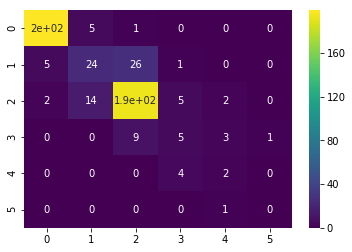

In [26]:
import seaborn as sns
sns.heatmap(cm_logreg_df,annot=True,cmap='viridis')

In [27]:
y_pred_rfc=rfc.predict(X_test)
cm_rfc=confusion_matrix(y_test,y_pred_rfc)
cm_rfc_df=pd.DataFrame(cm_rfc,index=[0,1,2,3,4,5],columns=[0,1,2,3,4,5])
cm_rfc

array([[204,   0,   1,   0,   0,   0],
       [  4,  21,  31,   0,   0,   0],
       [  2,   3, 211,   1,   0,   0],
       [  0,   0,  14,   4,   0,   0],
       [  0,   0,   1,   5,   0,   0],
       [  0,   0,   0,   0,   1,   0]])

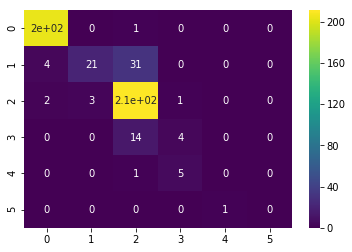

In [28]:
sns.heatmap(cm_rfc_df,annot=True,cmap='viridis')

### classification report

In [29]:
from sklearn.metrics import classification_report
report_logreg = classification_report(y_test, 
                      y_pred_logreg)
print(report_logreg)

             precision    recall  f1-score   support

        0.0       0.97      0.97      0.97       205
        1.0       0.56      0.43      0.48        56
        2.0       0.84      0.89      0.87       217
        3.0       0.33      0.28      0.30        18
        4.0       0.25      0.33      0.29         6
        5.0       0.00      0.00      0.00         1

avg / total       0.83      0.84      0.84       503



In [30]:
report_rfc = classification_report(y_test, 
                      y_pred_rfc)
print(report_rfc)

             precision    recall  f1-score   support

        0.0       0.97      1.00      0.98       205
        1.0       0.88      0.38      0.53        56
        2.0       0.82      0.97      0.89       217
        3.0       0.40      0.22      0.29        18
        4.0       0.00      0.00      0.00         6
        5.0       0.00      0.00      0.00         1

avg / total       0.86      0.87      0.85       503



In [31]:
y_pred_rfc_up=rfc_up.predict(X_test)
report_rfc_up = classification_report(y_test, 
                      y_pred_rfc_up)
print(report_rfc_up)

             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       205
        1.0       0.73      0.68      0.70        56
        2.0       0.89      0.93      0.91       217
        3.0       0.50      0.33      0.40        18
        4.0       0.50      0.17      0.25         6
        5.0       0.00      0.00      0.00         1

avg / total       0.88      0.89      0.89       503



## 5. Cross-Validation

In [33]:
from sklearn.cross_validation import LeaveOneOut, StratifiedKFold
from sklearn.model_selection import cross_val_score
#cv_score=cross_val_score(logreg,data,target,cv=5,n_jobs=-1)
#print(cv_score)

In [34]:
#print(cv_score.mean())

In [35]:
cv_score_rfc=cross_val_score(rfc,data,target,cv=5,n_jobs=-1)
print(cv_score_rfc)
print(cv_score_rfc.mean())

[0.82492582 0.8694362  0.85416667 0.82582583 0.83987915]
0.8428467328750393


## 6. Hyperparameter tuning with GridSearchCV

In [36]:
param_grid_rfc={'n_estimators':[5,10,15,20],
               'max_features':[5,10,15,20,50,100],
               'max_depth':[None,5,15,25,50],
               'max_leaf_nodes':[None,25,50,100,200],
               'min_samples_leaf':[1,5,10,15,20]}
from sklearn.model_selection import GridSearchCV
#grid_search=GridSearchCV(RandomForestClassifier(n_jobs=-1),param_grid_rfc,cv=5)

In [37]:
#grid_search.fit(X_train,y_train)

### automatic implementation via the cv sklearn library

In [ ]:
import sklearn.cross_validation as cv
# Helper to plot scikit CV
def plot_cv(cv):
    masks = []
    for train, test in cv: # this shows you how to use the cv results!
        # i.e. X_train, y_train = X[train], y[train]
        mask = np.zeros(cv.n, dtype=bool)
        mask[test] = 1
        masks.append(mask)
    
    plt.matshow(masks)
    
kfold = cv.StratifiedKFold(y, n_folds=10) # using it on the original multi-class labels
plot_cv(kfold)

### example of CV on iris dataset

In [ ]:
# Solution Exercise 2.2

from sklearn import grid_search
from sklearn.cross_validation import LeaveOneOut, StratifiedKFold

parameters = {
    'kernel':('linear', 'rbf'), 
    'C':[0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 50, 100]
}

svc = SVC()

# a)
clf = grid_search.GridSearchCV(svc, parameters, scoring='accuracy', cv=StratifiedKFold(y_virgin, 2))
clf.fit(X, y_virgin) 

best_clf_a = clf.best_estimator_

y_score = best_clf_a.decision_function(X)
fpr_a, tpr_a, _ = metrics.roc_curve(y_virgin, y_score, pos_label=1)

print("Best Classifier (2-fold): %s" % best_clf_a)
print("Best Accuracy (2-fold): %.4f" % clf.best_score_)
# b)
clf = grid_search.GridSearchCV(svc, parameters, scoring='accuracy', cv=LeaveOneOut(150))
clf.fit(X, y_virgin)   

best_clf_b = clf.best_estimator_

y_score = best_clf_b.decision_function(X)
fpr_b, tpr_b, _ = metrics.roc_curve(y_virgin, y_score, pos_label=1)
plot_roc_curves([fpr_a, fpr_b], [tpr_a, tpr_b])

print("Best Classifier (LOOCV): %s" % best_clf_b)
print("Best Accuracy (LOOCV): %.4f" % clf.best_score_)

In [ ]:
#mglearn.plots_plot_cross_validation

### validation curve? 

In [ ]:
import math
math.sqrt(370)

# II. Time-series prediction (input timestep=3)

In [38]:
def patients_selection(df, threshold=6):
    '''return a dataframe containing only the patients with number of visits > threshold'''
    if 'PATNO' in df.columns: 
        visits_number_by_pat=df.groupby('PATNO').size().sort_values(ascending=False)
        mask_sel=visits_number_by_pat>=threshold
        patients_sel=list(mask_sel[mask_sel.values==True].index)
        df=df.loc[df['PATNO'].isin(patients_sel),:]
        df=df.sort_values('PATNO')
        return (patients_sel, df)
    else:
        return 0

In [39]:
file_path='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/pre-processing/dfFinal.csv'
df2=pd.read_csv(file_path)
print(df2.shape)

df_th2=patients_selection(df,threshold=2)[1]
print(df_th2.shape)
df_th2['num_visits'].value_counts()

(4784, 379)
(4113, 376)


6    852
7    714
2    586
3    564
5    525
4    512
8    360
Name: num_visits, dtype: int64

### padding for patients with visits <4

In [56]:
rowstoAdd=df_th2[df_th2['num_visits']==2].groupby('PATNO').median()
rowstoAdd['VISIT_ID']=3
rowstoAdd['visitsdiff_days']=3*61
rowstoAdd['lastDate_diff_days']=rowstoAdd['lastDate_diff_days']-rowstoAdd['visitsdiff_days']
rowstoAdd['PDDXDT_diff_days']=rowstoAdd['PDDXDT_diff_days'].where(rowstoAdd['PDDXDT_diff_days']==0,
                                                                 rowstoAdd['PDDXDT_diff_days']+rowstoAdd['visitsdiff_days'])
maskMED=rowstoAdd['PDMEDT_diff_days']!=0
rowstoAdd.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd.loc[maskMED,'visitsdiff_days']
maskSURG=rowstoAdd['PDSURGDT_diff_days']!=0
rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd.loc[maskSURG,'visitsdiff_days']

rowstoAdd2=df_th2[df_th2['num_visits']==2].groupby('PATNO').median()
rowstoAdd2['VISIT_ID']=4
rowstoAdd2['visitsdiff_days']=3*61
rowstoAdd2['lastDate_diff_days']=rowstoAdd2['lastDate_diff_days']-rowstoAdd2['visitsdiff_days']
rowstoAdd2['PDDXDT_diff_days']=rowstoAdd2['PDDXDT_diff_days'].where(rowstoAdd2['PDDXDT_diff_days']==0,
                                                                 rowstoAdd2['PDDXDT_diff_days']+rowstoAdd2['visitsdiff_days'])

rowstoAdd2.loc[maskMED,'PDMEDT_diff_days']=rowstoAdd2.loc[maskMED,'PDMEDT_diff_days']+rowstoAdd2.loc[maskMED,'visitsdiff_days']
rowstoAdd2.loc[maskSURG,'PDSURGDT_diff_days']=rowstoAdd2.loc[maskSURG,'PDSURGDT_diff_days']+rowstoAdd2.loc[maskSURG,'visitsdiff_days']


rows3toAdd=df_th2[df_th2['num_visits']==3].groupby('PATNO').median()
rows3toAdd['VISIT_ID']=4
rows3toAdd['visitsdiff_days']=3*61
rows3toAdd['lastDate_diff_days']=rows3toAdd['lastDate_diff_days']-rows3toAdd['visitsdiff_days']
rows3toAdd['PDDXDT_diff_days']=rows3toAdd['PDDXDT_diff_days'].where(rows3toAdd['PDDXDT_diff_days']==0,
                                                                 rows3toAdd['PDDXDT_diff_days']+rows3toAdd['visitsdiff_days'])
mask3MED=rows3toAdd['PDMEDT_diff_days']!=0
rows3toAdd.loc[mask3MED,'PDMEDT_diff_days']=rows3toAdd.loc[mask3MED,'PDMEDT_diff_days']+rows3toAdd.loc[mask3MED,'visitsdiff_days']
mask3SURG=rows3toAdd['PDSURGDT_diff_days']!=0
rows3toAdd.loc[mask3SURG,'PDSURGDT_diff_days']=rows3toAdd.loc[mask3SURG,'PDSURGDT_diff_days']+rows3toAdd.loc[mask3SURG,'visitsdiff_days']

rowspadding=pd.concat([rowstoAdd,rowstoAdd2,rows3toAdd])
rowspadding['num_visits']=4
rowspadding.reset_index(inplace=True)
print(rowspadding.shape)
dfpad_th4=df_th2.drop(columns='INFODT_date')
print(dfpad_th4.shape)
dfpad_th4=pd.concat([dfpad_th4,rowspadding])
print(dfpad_th4.shape)
dfpad_th4['num_visits'].replace(2,4,inplace=True)
dfpad_th4['num_visits'].replace(3,4,inplace=True)
dfpad_th4.reset_index(drop=True,inplace=True)
dfpad_th4.head()
print((len(rowstoAdd),len(rows3toAdd)))

(774, 375)
(4113, 375)
(4887, 375)
(293, 188)


### cropping for number of visits > 4

In [57]:
dfpad_th4['visits_thresold']=dfpad_th4['VISIT_ID']-(dfpad_th4['num_visits']-4)
print(dfpad_th4.shape)
rowsToDrop=dfpad_th4[(dfpad_th4['num_visits']>4) & (dfpad_th4['visits_thresold']<=0)].index
print(len(rowsToDrop))
dfpaddrop_th4=dfpad_th4.drop(index=list(rowsToDrop),columns='visits_thresold')
dfpaddrop_th4['NHY']=dfpaddrop_th4['NHY'].apply(lambda x: round(x,0))
print(dfpaddrop_th4.shape)
print('number pf patients:{}'.format(len(set(dfpaddrop_th4['PATNO']))))
set(dfpaddrop_th4['NHY'])

(4887, 376)
875
(4012, 375)
number pf patients:1003


{0.0, 1.0, 2.0, 3.0, 4.0, 5.0}

### creating data and targets

In [46]:
datatoDrop=dfpaddrop_th4[dfpaddrop_th4['num_visits']==dfpaddrop_th4['VISIT_ID']]
data_TS=dfpaddrop_th4.drop(index=list(datatoDrop.index),columns=['MSEADLG'])
print(data_TS.shape)
data_TS.sort_values(['PATNO','VISIT_ID'],inplace=True)
data_TS.set_index(keys=['PATNO'],inplace=True)
data_TS.head(10)

(3009, 374)


,NP1COG,NP1HALL,NP1DPRS,NP1ANXS,NP1APAT,NP1DDS,NP2SPCH,NP2SALV,NP2SWAL,NP2EAT,...,DXPOSINS,DXOTHSX,DOMSIDE,num_visits,VISIT_ID,visitsdiff_days,lastDate_diff_days,PDDXDT_diff_days,PDMEDT_diff_days,PDSURGDT_diff_days
PATNO,,,,,,,,,,,,,,,,,,,,,
3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,2.0,7,4,335,1552.0,1461.0,0.0,0.0
3001,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,2.0,7,5,365,1187.0,1826.0,0.0,0.0
3001,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,2.0,7,6,427,760.0,2253.0,0.0,0.0
3002,2.0,0.0,3.0,1.0,2.0,0.0,1.0,1.0,1.0,1.0,...,0.0,1.0,1.0,6,3,365,1917.0,1155.0,0.0,0.0
3002,1.0,1.0,0.0,2.0,0.0,1.0,2.0,3.0,1.0,1.0,...,0.0,1.0,1.0,6,4,699,1218.0,1854.0,0.0,0.0
3002,2.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1.0,2.0,...,0.0,1.0,1.0,6,5,397,821.0,2251.0,0.0,0.0
3003,0.0,0.0,0.0,2.0,0.0,0.0,2.0,0.0,1.0,1.0,...,1.0,1.0,2.0,7,4,365,1552.0,1857.0,0.0,0.0
3003,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,...,1.0,1.0,2.0,7,5,365,1187.0,2222.0,0.0,0.0
3003,1.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,1.0,...,1.0,1.0,2.0,7,6,366,821.0,2588.0,0.0,0.0


In [ ]:
targettoDrop=dfpaddrop_th4[dfpaddrop_th4['VISIT_ID']==dfpaddrop_th4['num_visits']-3]
len(targettoDrop)
target_TS=dfpaddrop_th4.drop(index=list(datatoDrop.index))
target_TS.sort_values(['PATNO','VISIT_ID'],inplace=True)
target_TS.set_index(keys=['PATNO'],inplace=True)
target_TS=target_TS['NHY']
print(target_TS.shape)
list(set(target_TS.values))

### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg_TS = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0)
#cv_score_TS_reg=cross_val_score(logreg_TS,data_TS,target_TS,cv=5,n_jobs=-1)

## III. Without cropping (time series of different length witn min length=4)

In [58]:
dfpad_th4['NHY']=dfpad_th4['NHY'].apply(lambda x: round(x,0))
dfpad_th4.sort_values(['PATNO','VISIT_ID'],inplace=True)
dfpad_th4.shape

(4887, 376)

In [220]:
datatoDrop=dfpad_th4[dfpad_th4['num_visits']==dfpad_th4['VISIT_ID']]
print(datatoDrop.shape)
data_TS=dfpad_th4.drop(index=list(datatoDrop.index),columns=['MSEADLG','visits_thresold'])
data_TS.set_index(keys=['PATNO'],inplace=True)
print(data_TS.shape)
dd=data_TS['NHY']

(1003, 376)
(3884, 373)


In [224]:
targettoDrop=dfpad_th4[dfpad_th4['VISIT_ID']==1]
print(targettoDrop.shape)
target_TS=dfpad_th4.drop(index=list(targettoDrop.index))
target_TS.set_index(keys=['PATNO'],inplace=True)
assert len(target_TS)==len(data_TS)
assert set(data_TS.index)==set(target_TS.index)
target_TS=target_TS['NHY']
print(target_TS.shape)
list(set(target_TS.values))

(1003, 376)
(3884,)


[0.0, 1.0, 2.0, 3.0, 4.0, 5.0]

### Training ML models (Logistic Regression, RandomForest, XGBoost)

#### custom train/test split for time-series data

In [250]:
print(round(0.2*len(set(data_TS.index)),0))

201.0


In [257]:
random.seed(123)
#random.setstate()
pat_testset=random.sample(set(data_TS.index),201)
X_test=data_TS.loc[pat_testset,:]
X_test.head(50)
print(X_test.shape)
X_train=data_TS.drop(index=pat_testset)
print(X_train.shape)
y_test=target_TS[pat_testset]
print(y_test.shape)
assert set(y_test.index)==set(X_test.index)
y_train=target_TS.drop(index=pat_testset)
print(y_train.shape)
assert set(y_train.index)==set(X_train.index)

ValueError: state with version 1 passed to Random.setstate() of version 3

#### DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier
dummy=DummyClassifier()
dummy.fit(X_train, y_train)

In [ ]:
print("Train-Score-dummy: %.4f, Test-Accuracy-dummy: %.4f" % (dummy.score(X_train, y_train), dummy.score(X_test, y_test)))

#### Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg_TS = LogisticRegression(multi_class='multinomial',solver='newton-cg',random_state=0)
logreg_TS.fit(X_train, y_train)

In [ ]:
print("Train-Score-logreg: %.4f, Test-Accuracy-logreg: %.4f" % (logreg_TS.score(X_train, y_train), logreg_TS.score(X_test, y_test)))

#### Random Forest

In [ ]:
rfc_TS = RandomForestClassifier(n_estimators=100, random_state=1,n_jobs=-1)
rfc_TS.fit(X_train, y_train)

In [ ]:
print("Train-Score-rfc: %.4f, Test-Accuracy-rfc: %.4f" % (rfc_TS.score(X_train, y_train), rfc_TS.score(X_test, y_test)))

### PLotting the results. 

In [ ]:
y_pred_logreg=logreg_TS.predict(X_test)
predictions_logreg=pd.Series(y_pred_logreg,index=y_test.index)

y_test_pred_logreg=pd.concat([y_test,predictions_logreg],axis=1)
y_test_pred_logreg.rename(columns={'NHY':'trueLabel',0:'prediction_logreg'},inplace=True)

VISIT_ID=[2]
for i in range(1,len(y_test_pred_logreg)):
    if (y_test_pred_logreg.index[i]==y_test_pred_logreg.index[i-1]):
        visit=VISIT_ID[len(VISIT_ID)-1]+1
    else:
        visit=2
    VISIT_ID.append(visit)
print(len(VISIT_ID))
y_test_pred_logreg['VISIT_ID_future']=VISIT_ID

y_pred_rfc=pd.Series(rfc_TS.predict(X_test),index=y_test.index)
y_pred_rfc.name='prediction_rfc'

test_all=pd.concat([X_test,y_test_pred_logreg, y_pred_rfc],axis=1)
print(len(test_all_logreg))
results_toplot=test_all[['num_visits','VISIT_ID','NHY','VISIT_ID_future','trueLabel','prediction_logreg','prediction_rfc']]
results_toplot.reset_index(inplace=True)
results_toplot.head()

In [ ]:
def patients_sampling(df,sample_size=25,seed=123):
    np.random.seed(seed)
    sample=list(np.random.randint(0,len(set(df['PATNO'])),sample_size+1))
    patients_sample=pd.Series(list(set(df['PATNO'])))[sample]
    patients_sample=list(patients_sample.values)
    sub_df=df.loc[df['PATNO'].isin(patients_sample),:]
    return sub_df
df_toPlot=patients_sampling(results_toplot)

import seaborn as sns
sns.set(style="darkgrid")
g = sns.FacetGrid(df_toPlot, col="PATNO", margin_titles=True,col_wrap=5)
g.map(plt.scatter,x=df_toPlot['VISIT_ID'],y=df_toPlot['NHY'], color="steelblue")
plt.subplots_adjust(top=0.9)
g.fig.suptitle('plot of NHY true labels versus prediction')


#plt_path_name='/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/EDA/hist_visits_feat'
#plt_path_name=plt_path_name+fig_name
#g.savefig(plt_path_name)
#plt.close()

In [ ]:
fig = plt.figure(figsize=(60,60))
num_pat=len(set(df_toPlot['PATNO']))
for pat,num in zip(list(set(df_toPlot['PATNO'])),range(1,num_pat+1)):
    df0=df_toPlot[df_toPlot['PATNO']==pat]
    ax = fig.add_subplot(5,5,num)
    ax.plot(df0['VISIT_ID'], df0['NHY'],marker='o', markerfacecolor='blue', markersize=15, 
            color='skyblue', linewidth=4,label='NHY history')
    ax.plot(df0['VISIT_ID_future'], df0['trueLabel'],marker='o',markersize=15,
            color='blue',linestyle='dashed',linewidth=4,label='True Label')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_logreg'], marker='x', 
            color='black', linewidth=4, linestyle='dotted', label='logreg')
    ax.plot(df0['VISIT_ID_future'], df0['prediction_rfc'], marker='x', 
            color='green', linewidth=4, linestyle='dotted', label='rfc')
    ax.set_xlim([0.5, 8.5])
    ax.set_ylim([-0.5, 5])
    ax.set_title(pat,fontdict={'fontsize':20})
    ax.legend(fontsize='x-large')
    
#plt.plot('VISIT_ID', 'NHY', data=results_toplot, marker='o', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=4,label='NHY history')
#plt.plot('VISIT_ID_future', 'trueLabel', data=results_toplot, marker='o',color='blue',linestyle='dashed',linewidth=4,label='True Label')
#plt.plot('VISIT_ID_future', 'prediction_logreg', data=df, marker='', color='yellow', linewidth=2, linestyle='dashed', label='logreg')
#plt.plot('VISIT_ID_future', 'prediction_rcf', data=df, marker='', color='green', linewidth=2, linestyle='dashed', label='rcf')
#plt.legend()
plt.tight_layout()
#fig.figure.suptitle('true labels vs predictions')
plt.savefig('/Users/alicemartin/02_DSR_Project/parkinson-disease-project/output/ML_predictions/predictions_graph_123.png')
plt.show()       

### Features importance

In [ ]:
feature_importances = pd.DataFrame(rfc_TS.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance',ascending=False)
ImportantFeatures_TS=feature_importances[feature_importances.values>=0.01]
print(ImportantFeatures.values.sum())
ImportantFeatures_TS
#feature_importances